In [97]:
#### https://www.kaggle.com/dikshabhati2002/let-s-classify-audio-ml-dl

import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.io import wavfile as wav
import pandas as pd
import math
import os
import numpy as np
import seaborn as sns
import json


from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
import catboost as cb

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

In [98]:
sample_rate = 22050
sr = 22050     # sample rate. based on Nyquist frequency, we only care about frequencies up to 10kHz therefor the sample rate will only perserve those frequencies 
n_fft = 2048
hop_length = 512
duration = 29 # length of song to be used (in seconds) 
n_mels=128
samples_per_track = sr * duration
n_mfcc = 40

json_path = r"data.json"

In [99]:
# set a path pointing to folder with data
filepath = '/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original'
# folders contain different genres (classes), lets list all the genres
print(list(os.listdir(f'{filepath}/')))

['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']


In [100]:
# load csv with metadata
df = pd.read_csv('/Users/stephen/Flatiron/Phase4/MIR/Data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [101]:
df.shape

(9990, 60)

In [102]:
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [103]:
df['label'].value_counts()

blues        1000
jazz         1000
metal        1000
pop          1000
reggae       1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: label, dtype: int64

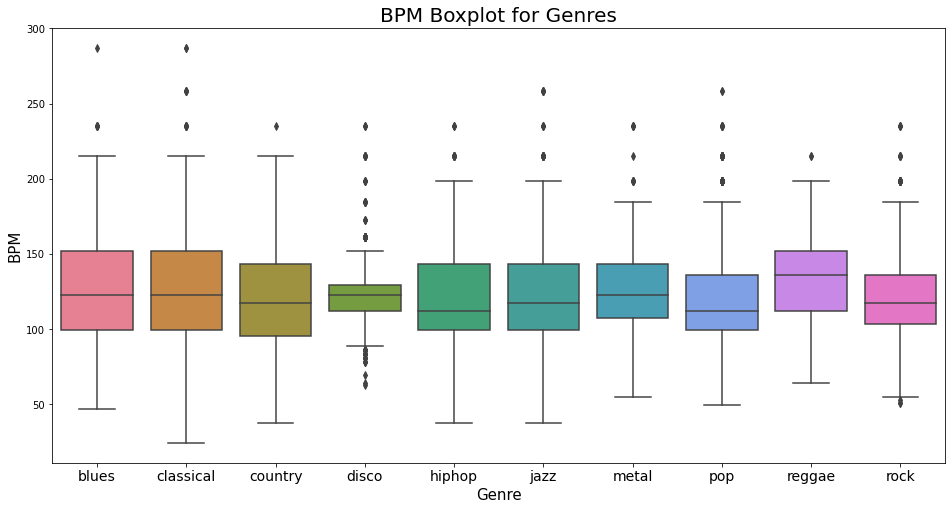

In [104]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

In [105]:
# load metadata csv
df = pd.read_csv('/Users/stephen/Flatiron/Phase4/MIR/Data/features_30_sec.csv')
df = df[['filename', 'label']]

# relative path to the directory of audio file genre subfolders
rel_path = '../../Data/genres_original/'

# create relative path to each audio file
df['file_path'] = rel_path + df['label'] + '/' + df['filename']

# drop 'filename' column
df = df.drop(columns='filename')
df.head()

,label,file_path
0,blues,../../Data/genres_original/blues/blues.00000.wav
1,blues,../../Data/genres_original/blues/blues.00001.wav
2,blues,../../Data/genres_original/blues/blues.00002.wav
3,blues,../../Data/genres_original/blues/blues.00003.wav
4,blues,../../Data/genres_original/blues/blues.00004.wav


In [106]:
df.shape

(1000, 2)

In [107]:
# drop the corrupted song
df = df.drop(labels=554)

# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      999 non-null    object
 1   file_path  999 non-null    object
dtypes: object(2)
memory usage: 23.4+ KB


In [108]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
             hop_length=512, num_segments=5):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(samples_per_track/num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps/hop_length)
    
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")
            
            # process files for specific genre
            for f in filenames:
                if(f==str("jazz.00054.wav")):
                    # As librosa only read files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=sample_rate)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                    sr = sr,
                                                    n_fft = n_fft,
                                                    n_mfcc = n_mfcc,
                                                    hop_length = hop_length)

                        mfcc = mfcc.T

                        # store mfcc if it has expected length 
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print(f"{file_path}, segment: {s+1}")

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)
     

In [109]:
save_mfcc(filepath,json_path,num_segments=10)
#clear_output()

Processing: pop
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 1
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 2
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 3
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 4
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 5
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 6
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 7
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 8
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 9
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 10
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00033.wav, segment: 1
/Users/stephen/Flatiron/Phase4/MIR/Da

In [110]:
# loading in the data 
def load_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)

    # convert list to numpy arrays
    inputs = np.array(data['mfcc'])
    targets = np.array(data['labels'])

    return inputs, targets 

In [111]:
# set up variables 
inputs, targets = load_data(r'/Users/stephen/Flatiron/Phase4/MIR/data.json')
inputs.shape

(9990, 125, 13)

In [112]:
# splitting the data 
# input_train, input_test, target_train, target_test
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3)
print(X_train.shape, y_train.shape)

(6993, 125, 13) (6993,)


In [113]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 1625)              0         
                                                                 
 dense_27 (Dense)            (None, 512)               832512    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 64)                16448     
                                                                 
 dropout_12 (Dropout)        (None, 64)               

In [114]:
adam = optimizers.Adam(learning_rate=1e-4)

In [115]:
model.compile(optimizer=adam, 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy'])

hist = model.fit(X_train, y_train, 
                validation_data = (X_test, y_test), 
                epochs = 100, 
                batch_size = 32)



Epoch 1/100
219/219 [==============================] - 2s 7ms/step - loss: 14.8077 - accuracy: 0.1293 - val_loss: 5.0257 - val_accuracy: 0.0938
Epoch 2/100
219/219 [==============================] - 2s 7ms/step - loss: 6.3422 - accuracy: 0.1300 - val_loss: 5.0105 - val_accuracy: 0.1692
Epoch 3/100
219/219 [==============================] - 1s 6ms/step - loss: 5.4728 - accuracy: 0.1321 - val_loss: 5.0002 - val_accuracy: 0.1502
Epoch 4/100
219/219 [==============================] - 1s 6ms/step - loss: 5.2479 - accuracy: 0.1414 - val_loss: 4.9553 - val_accuracy: 0.1588
Epoch 5/100
219/219 [==============================] - 1s 6ms/step - loss: 5.0947 - accuracy: 0.1371 - val_loss: 4.9282 - val_accuracy: 0.1498
Epoch 6/100
219/219 [==============================] - 1s 6ms/step - loss: 5.0100 - accuracy: 0.1484 - val_loss: 4.8339 - val_accuracy: 0.1748
Epoch 7/100
219/219 [==============================] - 1s 6ms/step - loss: 4.9184 - accuracy: 0.1772 - val_loss: 4.7665 - val_accuracy: 0.242

In [116]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()


<Figure size 1440x1080 with 0 Axes>

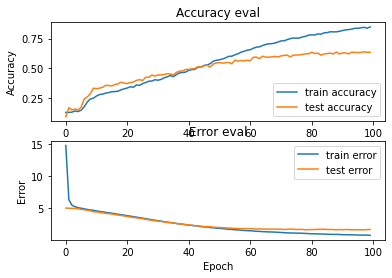

In [117]:
plot_history(hist)

In [118]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 2ms/step - loss: 1.7016 - accuracy: 0.6340
Test accuracy: 0.6339672803878784


In [120]:
out = model.predict(X_test)
out.shape

(2997, 10)

In [121]:
X_test.shape

(2997, 125, 13)